In [1]:
%matplotlib inline
import numpy as np
import csv
import itertools
import matplotlib.pyplot as plt
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from scipy import interp
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import ExtraTreesClassifier

In [2]:
def smiles_to_fps(smiles, fp_radius, fp_length):
    """This function converts an array of SMILES to an array of Morgan fingerprints"""
    fps = np.array([smile_to_fp(s, fp_radius, fp_length) for s in smiles])  # get the bit strings
    return np.array([list(fp) for fp in fps], dtype=int)  # convert the bit strings to integer arrays


def smile_to_fp(s, fp_radius, fp_length):
    """This function converts SMILES to Morgan fingerprints"""
    mol = Chem.MolFromSmiles(s)  # get molecule object
    return (AllChem.GetMorganFingerprintAsBitVect(  # get fingerprint
        mol, fp_radius, nBits=fp_length)).ToBitString()  # convert it to bit string for speed


def read_csv(filename, input_name, target_name):
    """This function reads a csv file with an input column and a target column"""
    x = []  # SMILES
    y = []  # enzyme class
    with open(filename) as file:
        reader = csv.DictReader(file)
        for row in reader:
            x.append(row[input_name])
            y.append(int(row[target_name]))
    return np.array(x), np.array(y)


# read csv file
x, y = read_csv('pdb_data_protein_mc.csv', 'smiles', 'class')

# convert SMILES to Morgan fingerprints (ECFP4)
X = smiles_to_fps(x, 2, 8192)

In [3]:
# training data for classes 0 and 5 (hydrolase and transferase)
X_b = np.append(X[y==0], X[y==5], axis=0)
# test data
y_b = np.append(y[y==0], y[y==5], axis=0)
y_b[y_b==5] = 1

In [4]:
# binarize the labels
y2 = []
for i in range(len(y_b)):
    if y_b[i]==[0]:
        y2.append([1, 0])
    elif y_b[i]==[1]:
        y2.append([0, 1])
y2 = np.array(y2)

In [5]:
n_samples, n_features = X_b.shape
random_state = np.random.RandomState(0)
n_classes = 2
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)
classifier = ExtraTreesClassifier(n_estimators=700, max_features='log2', class_weight="balanced", n_jobs=-1, random_state=999)

# Variables initialization
tprs = []
aucs = []
mean_fpr = []
for j in range(n_classes):
    mean_fpr.append(np.linspace(0, 1, 100))
    tprs.append([])
    aucs.append([])

fpr = n_classes*[0]
tpr = n_classes*[0]
thresholds = n_classes*[0]
roc_auc = n_classes*[0]

mean_tpr = n_classes*[0]
mean_auc = n_classes*[0]
std_auc = n_classes*[0]
std_tpr = n_classes*[0]
tprs_upper = n_classes*[0]
tprs_lower = n_classes*[0]
i = 0

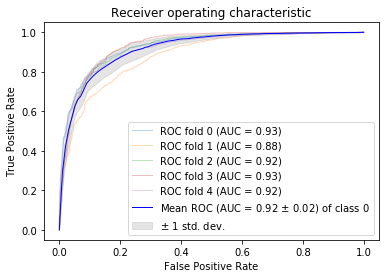

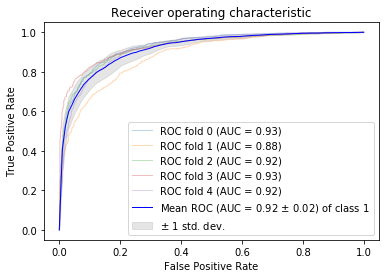

In [6]:
for train, test in cv.split(X_b, y_b):
    probas_ = classifier.fit(X_b[train], y_b[train]).predict_proba(X_b[test])
    # Compute ROC curve and area the curve
    for j in range(n_classes):
        plt.figure(j)
        fpr[j], tpr[j], thresholds[j] = roc_curve(y2[test][:, j], probas_[:, j])
        tprs[j].append(interp(mean_fpr[j], fpr[j], tpr[j]))
        tprs[j][-1][0] = 0.0
        roc_auc[j] = auc(fpr[j], tpr[j])
        aucs[j].append(roc_auc[j])
        plt.plot(fpr[j], tpr[j], lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc[j]))
    i += 1

            
for j in range(n_classes):
    # plot the ROC curve for each class
    plt.figure(j)
    mean_tpr[j] = np.mean(tprs[j], axis=0)
    mean_tpr[j][-1] = 1.0
    mean_auc[j] = auc(mean_fpr[j], mean_tpr[j])
    std_auc[j] = np.std(aucs[j])
    plt.plot(mean_fpr[j], mean_tpr[j], color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f) of class %d' % (mean_auc[j], std_auc[j], j),
         lw=1, alpha=1)
    std_tpr[j] = np.std(tprs[j], axis=0)
    tprs_upper[j] = np.minimum(mean_tpr[j] + std_tpr[j], 1)
    tprs_lower[j] = np.maximum(mean_tpr[j] - std_tpr[j], 0)
    plt.fill_between(mean_fpr[j], tprs_lower[j], tprs_upper[j], color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

plt.show()

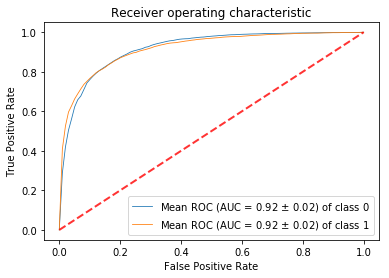

In [7]:
# plot the mean ROC curves for all classes
plt.figure(n_classes)
for j in range(n_classes):
    mean_tpr[j] = np.mean(tprs[j], axis=0)
    mean_tpr[j][-1] = 1.0
    plt.plot(mean_fpr[j], mean_tpr[j],
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f) of class %d' % (mean_auc[j], std_auc[j], j),
         lw=0.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)
plt.show()

In [8]:
# #############################################################################
# Classification and Confusion Matrix
clf = ExtraTreesClassifier(n_estimators=700, class_weight="balanced", max_features='log2', random_state=999, n_jobs=-1)
preds = cross_val_predict(clf, X_b, y_b, cv=5, n_jobs=-1)
f1_score(y_b, preds, average="weighted")

0.8384955256857521

In [9]:
np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(y_b, preds)
class_names = ['hydrolase', 'transferase']

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.4)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[4074 1050]
 [ 708 5085]]
Normalized confusion matrix
[[0.8  0.2 ]
 [0.12 0.88]]


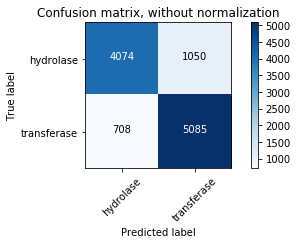

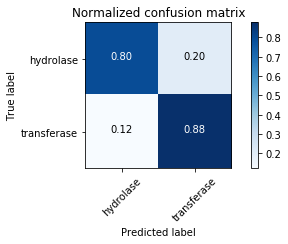

In [11]:
# Plot non-normalized confusion matrix
plt.figure(0)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(1)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
